In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
from matplotlib import patches
%load_ext watermark
%watermark -a "Florian Tesson" -d -v -p pandas,numpy,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Florian Tesson

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

pandas    : 1.4.0
numpy     : 1.24.4
matplotlib: 3.8.3
seaborn   : 0.13.2



In [2]:
bact=pd.read_table('data/figures/SuppData2_ADF_RefSeq.tsv',sep='\t')
phage=pd.read_table('data/figures/SuppData3_ADF_Phage.tsv',sep='\t')
phylo=pd.read_table('data/figures/phylo_bact.tsv',sep='\t')
phylo_phage=pd.read_table('data/figures/Taxonomy_phage.tsv',sep='\t')
phage['Activity']=phage.model_fqn.map(lambda x: x.split('/')[1])

## Figure 2

### Figure 2 A and B

In [3]:
esco=bact.loc[bact.Genus=='Escherichia'].drop_duplicates('sys_id')
pseudo=bact.loc[bact.Genus=='Pseudomonas'].drop_duplicates('sys_id')
bacillus=bact.loc[bact.Genus=='Bacillus'].drop_duplicates('sys_id')
esco_phage=phage.loc[phage.Genus_source=='Escherichia'].drop_duplicates('sys_id')
pseudo_phage=phage.loc[phage.Genus_source=='Pseudomonas'].drop_duplicates('sys_id')
bacillus_phage=phage.loc[phage.Genus_source=='Bacillus'].drop_duplicates('sys_id')


In [4]:
nb_esco=len(phylo.loc[phylo.Genus=='Escherichia'].drop_duplicates('Assembly'))
nb_pseudo=len(phylo.loc[phylo.Genus=='Pseudomonas'].drop_duplicates('Assembly'))
nb_bacillus=len(phylo.loc[phylo.Genus=='Bacillus'].drop_duplicates('Assembly'))


nb_esco_phage=len(phylo_phage.loc[phylo_phage.Genus_source=='Escherichia'])
nb_pseudo_phage=len(phylo_phage.loc[phylo_phage.Genus_source=='Pseudomonas'])
nb_bacillus_phage=len(phylo_phage.loc[phylo_phage.Genus_source=='Bacillus'])

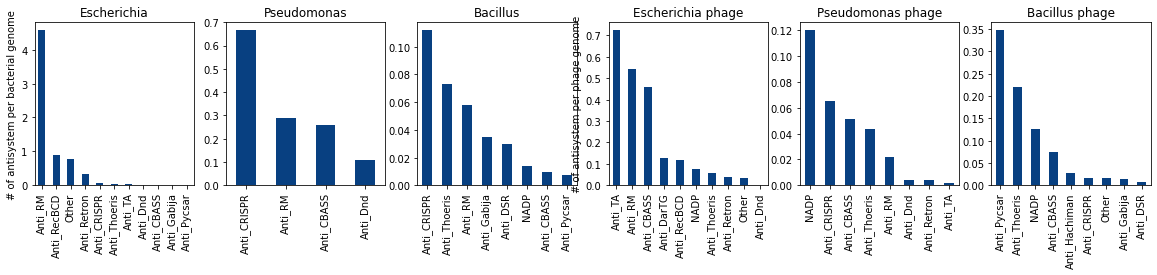

In [5]:
fig,ax=plt.subplots(1,6,figsize=(20,3))
(esco.Activity.value_counts(normalize=False)/nb_esco).plot.bar(stacked=True,color='#084081',ax=ax[0])
(pseudo.Activity.value_counts(normalize=False)/nb_pseudo).plot.bar(stacked=True,color='#084081',ax=ax[1])
(bacillus.Activity.value_counts(normalize=False)/nb_bacillus).plot.bar(stacked=True,color='#084081',ax=ax[2])
(esco_phage.Activity.value_counts()/nb_esco_phage).plot.bar(stacked=True,color='#084081',ax=ax[3])
(pseudo_phage.Activity.value_counts()/nb_pseudo_phage).plot.bar(stacked=True,color='#084081',ax=ax[4])
(bacillus_phage.Activity.value_counts()/nb_bacillus_phage).plot.bar(stacked=True,color='#084081',ax=ax[5])


ax[0].set_ylabel('# of antisystem per bacterial genome')
ax[0].set_title('Escherichia')
ax[1].set_title('Pseudomonas')
ax[2].set_title('Bacillus')
ax[3].set_ylabel('# of antisystem per phage genome')
ax[3].set_title('Escherichia phage')
ax[4].set_title('Pseudomonas phage')
ax[5].set_title('Bacillus phage')
plt.rcParams['pdf.fonttype']=42
plt.savefig('results/figures/Figure2AB.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Figure 2C

In [6]:
phylo['ID']=phylo.replicon.map(lambda x: ".".join(x.split('.')[0:-1]))

genus_top_10=bact.drop_duplicates('sys_id').Genus.value_counts()[0:10].index
Nb_genus=phylo.drop_duplicates('ID').Genus.value_counts().reset_index().rename({'Genus':'Nb_genus',"index":'Genus'},axis=1)

top10=bact.drop_duplicates('sys_id').loc[bact.Genus.isin(Nb_genus.Genus[0:20])]
top10.System.value_counts()[top10.System.value_counts()>0]
nb_sys=top10.drop_duplicates('sys_id').groupby(['Genus','Activity']).System.value_counts().to_frame().rename({'System':'Nb_sys'},axis=1).reset_index()
nb_sys=nb_sys.merge(Nb_genus,on='Genus')
nb_sys['Mean_per_genus']=nb_sys.Nb_sys/nb_sys.Nb_genus
nb_sys_wide=nb_sys[['System','Genus','Mean_per_genus']].pivot_table(index='Genus',columns='System',values='Mean_per_genus').fillna(0)
order_phylo=phylo.loc[phylo.Genus.isin(Nb_genus.Genus[0:20])].sort_values(['Phylum','Class','Order','Family','Genus']).drop_duplicates('Genus').Genus
order_system=top10.groupby('Activity').System.value_counts()[top10.groupby('Activity').System.value_counts()>0].to_frame().rename({'System':'Nb_sys'},axis=1).reset_index().System
nb_sys_wide=nb_sys_wide.loc[order_phylo,order_system]

In [7]:
phage['System']=phage.model_fqn.map(lambda x: x.split('/')[-1])
phage_plot=phage.drop_duplicates('sys_id').groupby('Genus_source').System.value_counts().to_frame().rename({'System':'Nb_sys','index':'System'},axis=1).reset_index()
phage_plot=phage_plot.loc[phage_plot.Genus_source.isin(order_phylo)]
phage_plot=phage_plot.merge(phylo_phage.drop_duplicates('Assembly').Genus_source.value_counts().reset_index().rename({'Genus_source':'Nb_source','index':'Genus_source'},axis=1),on='Genus_source')
phage_plot['Mean_per_phage']=phage_plot.Nb_sys/phage_plot.Nb_source

phage_plot_wide=phage_plot.pivot_table(index='Genus_source',columns='System',values='Mean_per_phage').fillna(0)

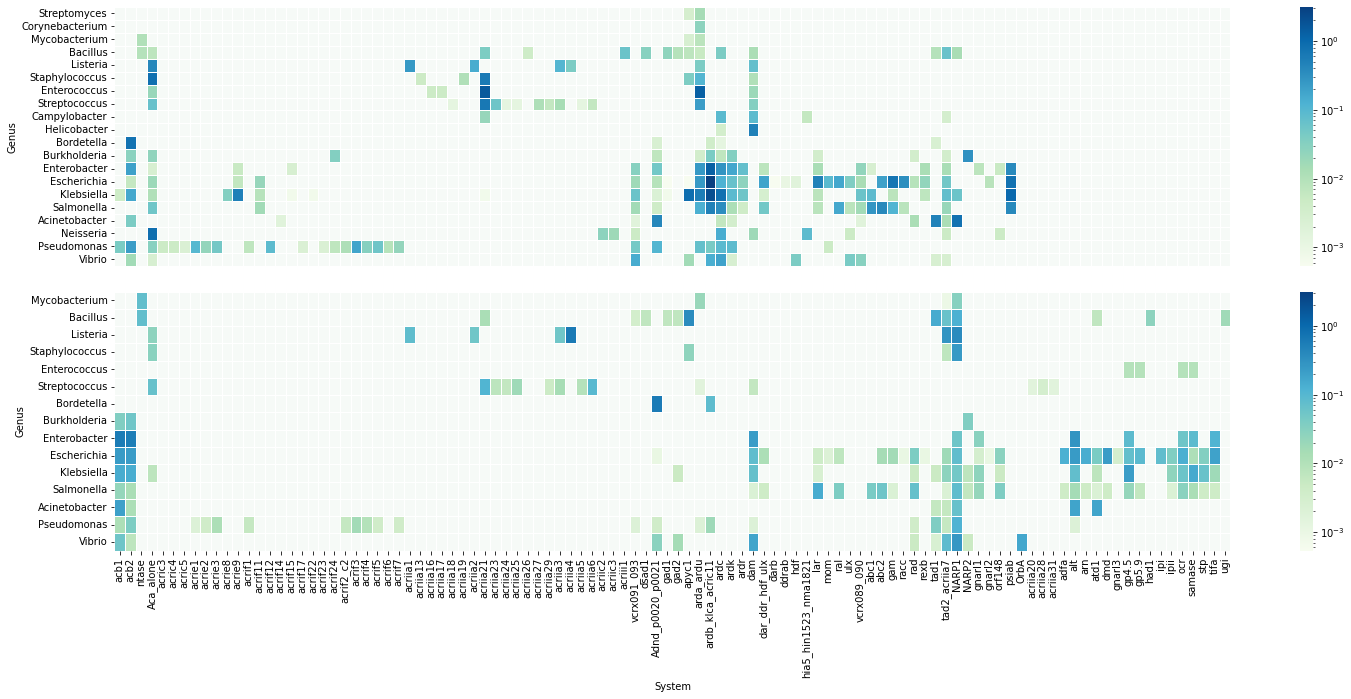

In [8]:
nb_sys
phage_plot['Type']='Phage'
nb_sys['Type']='Bacteria'
all_res=pd.concat([nb_sys.rename({'Mean_per_genus':'Mean_per_genome'},axis=1),phage_plot.rename({'Genus_source':'Genus','Mean_per_phage':'Mean_per_genome','Nb_source':'Nb_genus'},axis=1)])
all_res_wide=all_res.pivot_table(index=['Genus','Type'],columns=['System'],values=['Mean_per_genome']).fillna(0).droplevel(0,axis=1).reset_index()
# all_res_wide=all_res_wide.droplevel(0,axis=1)
order_columns=all_res.sort_values(["Activity",'System']).drop_duplicates('System').System

order_phylum=phylo.loc[phylo.Genus.isin(all_res.Genus)].sort_values(['Phylum','Order','Class','Family','Genus']).drop_duplicates('Genus').Genus

sns.set_style(rc = {'axes.facecolor': '#F6FAF7'})
fig,ax=plt.subplots(2,1,figsize=(25,10))
res_bact=all_res_wide.loc[all_res_wide.Type=='Bacteria'].drop(columns=['Type']).set_index('Genus')[order_columns]
sns.heatmap(res_bact.loc[order_phylum],ax=ax[0],cmap='GnBu',norm=LogNorm(vmin=all_res.Mean_per_genome.min(), vmax=all_res.Mean_per_genome.max()),linecolor='white',linewidths=1)

res_phage=all_res_wide.loc[all_res_wide.Type=='Phage'].drop(columns=['Type']).set_index('Genus')[order_columns]
order_phylum_phage=phylo.loc[phylo.Genus.isin(res_phage.index)].sort_values(['Phylum','Order','Class','Family','Genus']).drop_duplicates('Genus').Genus

sns.heatmap(res_phage.loc[order_phylum_phage],ax=ax[1],cmap='GnBu',norm=LogNorm(vmin=all_res.Mean_per_genome.min(), vmax=all_res.Mean_per_genome.max()),linecolor='white',linewidths=1)
ax[0].set_xticks([])
ax[0].set_xlabel(None)
plt.subplots_adjust(hspace=0.1)
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure2C.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Figure 3

### Figure 3A

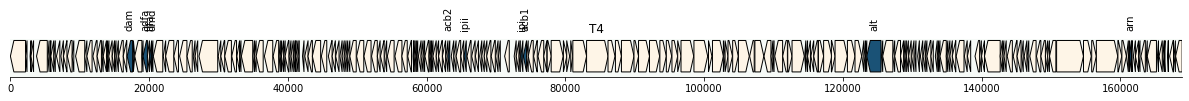

In [9]:
anti_draw=pd.read_table('data/figures/ADF_classic_phage.tsv',sep='\t')

gff=pd.read_table('data/figures/Gff/T4D.gff',sep='\t',comment='#',names=['Nuccore','Prodigal','Type','Start','End','X','Strand','X2','Infos'])
gff=gff.loc[gff.Type=='CDS']
gff=gff.loc[~gff.Infos.isna()]
gff['hit_id']=gff.Infos.map(lambda x: x.split(';')[0].split('=')[1])
gff['Color']='#FEF5E7' # Color of all the genes


fig,ax=plt.subplots(1,1,figsize=(21,.7))

tmp=anti_draw.loc[anti_draw.replicon=='T4D'] 
gff=gff.merge(tmp[['hit_id','gene_name']],on='hit_id',how='left')
gff.loc[~(gff.gene_name.isna()),'Color']='#1A5276' # In this case, if a gene is an antidefense system, new color

min_length=500 # Size in nucleotide of the arrow
for i in gff.index.to_list():
    if gff.Strand[i]=='+':
        arrow = patches.FancyArrow(gff.Start[i], 1, (gff.End[i]-gff.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax.add_patch(arrow)
    if gff.Strand[i]=='-':
        arrow = patches.FancyArrow(gff.End[i], 1, -(gff.End[i]-gff.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax.add_patch(arrow)
for i in gff.loc[~gff.gene_name.isna()].index.to_list():
    ax.text(x=(gff.Start[i]+gff.End[i])/2,y=1.8,s=gff.gene_name[i],rotation=90,verticalalignment='bottom',horizontalalignment='center') # Add the name of the antidefense system


ax.hlines(y=0.4,xmin=0,xmax=gff.End.max(),color='white',alpha=0)
ax.spines[['right', 'top','left']].set_visible(False)
ax.set_yticks([])
ax.set_xlim(0,gff.End.max())
ax.set_title('T4')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure3A_T4.pdf',format='pdf',bbox_inches='tight')


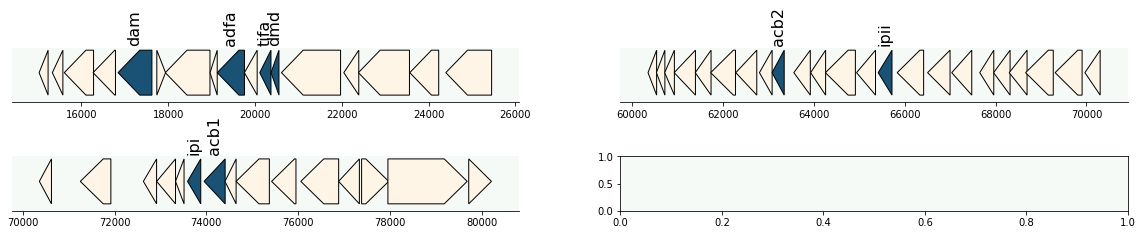

In [10]:
fig,ax=plt.subplots(2,2,figsize=(20,3))

plt.subplots_adjust(hspace=1)
region1=gff.loc[gff.Start.between(15000,25000)]

for i in region1.index.to_list():
    if region1.Strand[i]=='+':
        arrow = patches.FancyArrow(region1.Start[i], 1, (region1.End[i]-region1.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((region1.End[i]-region1.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax[0,0].add_patch(arrow)
    if region1.Strand[i]=='-':
        arrow = patches.FancyArrow(region1.End[i], 1, -(region1.End[i]-region1.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((region1.End[i]-region1.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax[0,0].add_patch(arrow)
ax[0,0].hlines(y=0.4,xmin=region1.Start.min()-100,xmax=region1.End.max()+100,color='white',alpha=0)

ax[0,0].spines[['right', 'top','left']].set_visible(False)
ax[0,0].set_yticks([])
for i in region1.loc[~region1.gene_name.isna()].index.to_list():
    ax[0,0].text(x=(region1.Start[i]+region1.End[i])/2,y=1.6,s=region1.gene_name[i],rotation=90,verticalalignment='bottom',horizontalalignment='center',size=16)
    
region2=gff.loc[gff.Start.between(60000,70000)]

for i in region2.index.to_list():
    if region2.Strand[i]=='+':
        arrow = patches.FancyArrow(region2.Start[i], 1, (region2.End[i]-region2.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((region2.End[i]-region2.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax[0,1].add_patch(arrow)
    if region2.Strand[i]=='-':
        arrow = patches.FancyArrow(region2.End[i], 1, -(region2.End[i]-region2.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((region2.End[i]-region2.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax[0,1].add_patch(arrow)
ax[0,1].hlines(y=0.4,xmin=region2.Start.min()-100,xmax=region2.End.max()+100,color='white',alpha=0)

ax[0,1].spines[['right', 'top','left']].set_visible(False)
ax[0,1].set_yticks([])
for i in region2.loc[~region2.gene_name.isna()].index.to_list():
    ax[0,1].text(x=(region2.Start[i]+region2.End[i])/2,y=1.6,s=region2.gene_name[i],rotation=90,verticalalignment='bottom',horizontalalignment='center',size=16)

region3=gff.loc[gff.Start.between(70000,80000)]

for i in region3.index.to_list():
    if region3.Strand[i]=='+':
        arrow = patches.FancyArrow(region3.Start[i], 1, (region3.End[i]-region3.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax[1,0].add_patch(arrow)
    if region3.Strand[i]=='-':
        arrow = patches.FancyArrow(region3.End[i], 1, -(region3.End[i]-region3.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax[1,0].add_patch(arrow)
ax[1,0].hlines(y=0.4,xmin=region3.Start.min()-100,xmax=region3.End.max()+100,color='white',alpha=0)

ax[1,0].spines[['right', 'top','left']].set_visible(False)
ax[1,0].set_yticks([])
for i in region3.loc[~region3.gene_name.isna()].index.to_list():
    ax[1,0].text(x=(region3.Start[i]+region3.End[i])/2,y=1.6,s=region3.gene_name[i],rotation=90,verticalalignment='bottom',horizontalalignment='center',size=16)


plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure3A_T4_part.pdf',format='pdf',bbox_inches='tight')


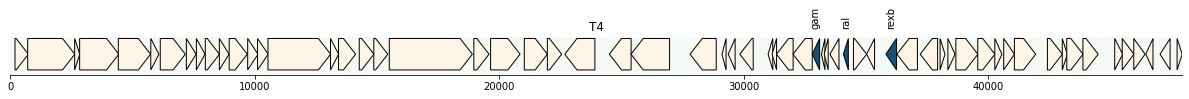

In [11]:
anti_draw=pd.read_table('data/figures/ADF_classic_phage.tsv',sep='\t')

gff=pd.read_table('data/figures/Gff/Lambdavir.gff',sep='\t',comment='#',names=['Nuccore','Prodigal','Type','Start','End','X','Strand','X2','Infos'])
gff=gff.loc[gff.Type=='CDS']
gff=gff.loc[~gff.Infos.isna()]
gff['hit_id']=gff.Infos.map(lambda x: x.split(';')[0].split('=')[1])
gff['Color']='#FEF5E7' # Color of all the genes


fig,ax=plt.subplots(1,1,figsize=(21,.7))

tmp=anti_draw.loc[anti_draw.replicon=='Lambdavir'] 
gff=gff.merge(tmp[['hit_id','gene_name']],on='hit_id',how='left')
gff.loc[~(gff.gene_name.isna()),'Color']='#1A5276' # In this case, if a gene is an antidefense system, new color

min_length=500 # Size in nucleotide of the arrow
for i in gff.index.to_list():
    if gff.Strand[i]=='+':
        arrow = patches.FancyArrow(gff.Start[i], 1, (gff.End[i]-gff.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax.add_patch(arrow)
    if gff.Strand[i]=='-':
        arrow = patches.FancyArrow(gff.End[i], 1, -(gff.End[i]-gff.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
        ax.add_patch(arrow)
for i in gff.loc[~gff.gene_name.isna()].index.to_list():
    ax.text(x=(gff.Start[i]+gff.End[i])/2,y=1.8,s=gff.gene_name[i],rotation=90,verticalalignment='bottom',horizontalalignment='center') # Add the name of the antidefense system


ax.hlines(y=0.4,xmin=0,xmax=gff.End.max(),color='white',alpha=0)
ax.spines[['right', 'top','left']].set_visible(False)
ax.set_yticks([])
ax.set_xlim(0,gff.End.max())
ax.set_title('T4')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure3A_Lambda.pdf',format='pdf',bbox_inches='tight')


### Supplementary figure

In [16]:
order_phage=['Lambdavir','N4','P1vir','PhiKZ','T2','T4D','T5','T6','T7','Bas31','Bas35','Bas46','Bas60','Bas63','Bas64','Bas69']
anti_draw.loc[anti_draw.gene_name.str.contains('narp1')]
anti_draw.loc[anti_draw.gene_name.str.contains('narp1'),'gene_name']=anti_draw.loc[anti_draw.gene_name.str.contains('narp1'),'gene_name'].map(lambda x: x.replace('narp1_',''))


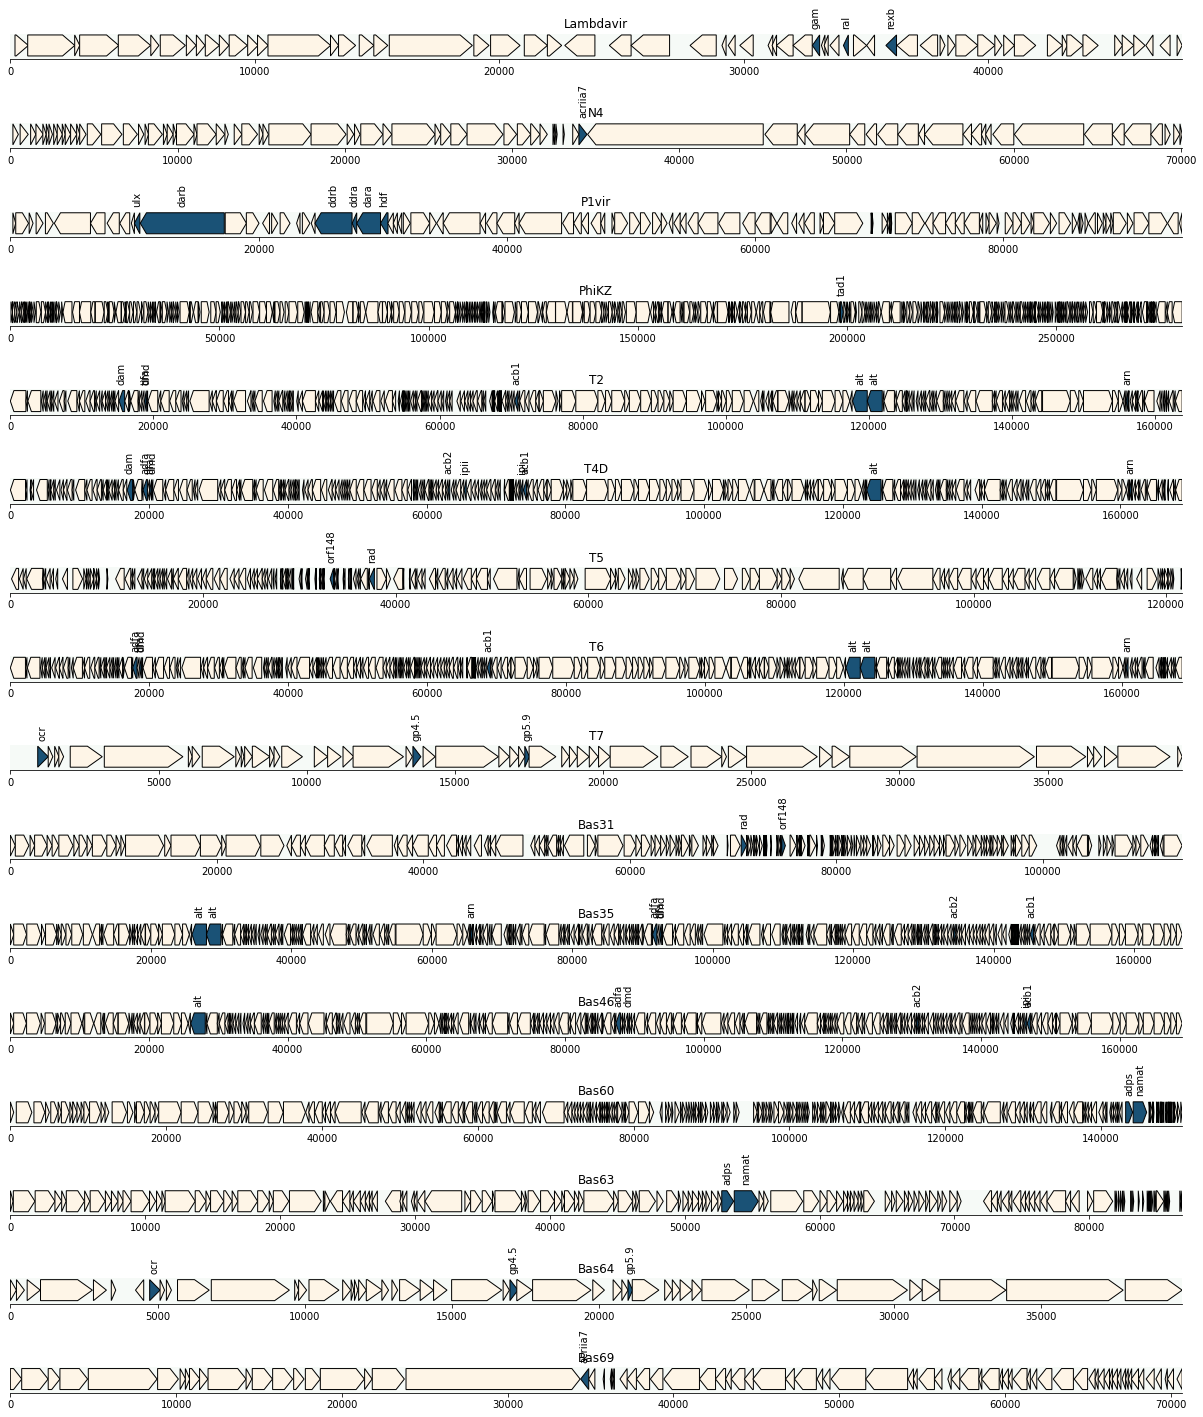

In [17]:
fig,ax=plt.subplots(16,1,figsize=(21,25))
plt.subplots_adjust(hspace=2.5)

for j in range(len(order_phage)):
    phage_name=order_phage[j]

    gff=pd.read_table('data/figures/Gff/'+phage_name+'.gff',sep='\t',comment='#',names=['Nuccore','Prodigal','Type','Start','End','X','Strand','X2','Infos'])
    gff=gff.loc[~gff.Infos.isna()]
    gff['hit_id']=gff.Infos.map(lambda x: x.split(';')[0].split('=')[1])
    gff['Color']='#FEF5E7'

    tmp=anti_draw.loc[anti_draw.replicon==phage_name]
    gff=gff.merge(tmp[['hit_id','gene_name']],on='hit_id',how='left')
    gff.loc[~(gff.gene_name.isna()),'Color']='#1A5276'

    min_length=500
    for i in gff.index.to_list():
        if gff.Strand[i]=='+':
            arrow = patches.FancyArrow(gff.Start[i], 1, (gff.End[i]-gff.Start[i]+1), 0,
                                    width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
            ax[j].add_patch(arrow)
        if gff.Strand[i]=='-':
            arrow = patches.FancyArrow(gff.End[i], 1, -(gff.End[i]-gff.Start[i]+1), 0,
                                    width=1,head_width=1,head_length=min((gff.End[i]-gff.Start[i]+1),min_length), length_includes_head=True, facecolor=gff.Color[i],edgecolor='black')
            ax[j].add_patch(arrow)
    for i in gff.loc[~gff.gene_name.isna()].index.to_list():
        ax[j].text(x=(gff.Start[i]+gff.End[i])/2,y=1.8,s=gff.gene_name[i],rotation=90,verticalalignment='bottom',horizontalalignment='center')


    ax[j].hlines(y=0.4,xmin=0,xmax=gff.End.max(),color='white',alpha=0)
    ax[j].spines[['right', 'top','left']].set_visible(False)
    ax[j].set_yticks([])
    ax[j].set_xlim(0,gff.End.max())
    ax[j].set_title(phage_name)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/SuppFigure_phage.pdf',format='pdf',bbox_inches='tight')


### Figure 3B

In [18]:
All_gff=pd.read_table('data/figures/Gff/Gff_figure3B.tsv',sep='\t').rename({'Replicon':'replicon'},axis=1)

In [19]:
All_gff['Colors']="#FEF5E7"
All_gff.loc[(All_gff.hit_id.isin(bact.hit_id))|(All_gff.hit_id.isin(phage.hit_id)),'Colors']='#084081'
A=pd.concat([bact[['hit_id','gene_name']],phage[['hit_id','gene_name']]]).reset_index(drop=True)
All_gff=All_gff.merge(A,on='hit_id',how='left').fillna('')

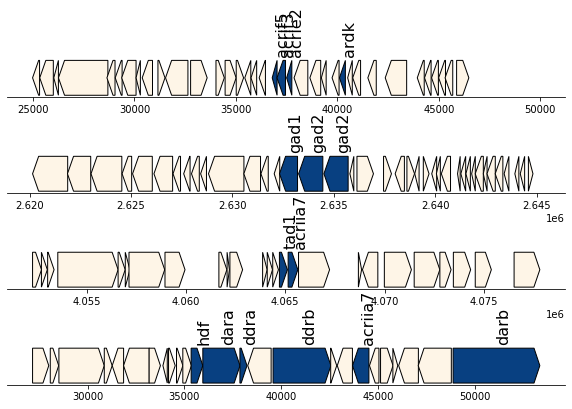

In [20]:
from matplotlib import patches
sns.set_style(rc = {'axes.facecolor': 'white'})

fig,ax=plt.subplots(4,1,figsize=(10,6),gridspec_kw={'height_ratios': [3,3,3,3]})
plt.subplots_adjust(hspace=1.5)
tmp=All_gff.loc[All_gff.replicon=="GCF_019710495.1_NZ_CP081204"]
for i in tmp.index.to_list():
    if tmp.Strand[i]=='D':
        arrow = patches.FancyArrow(tmp.Start[i], 1, (tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300),length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[0].add_patch(arrow)
    if tmp.Strand[i]=='C':
        arrow = patches.FancyArrow(tmp.End[i], 1, -(tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300),length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[0].add_patch(arrow)
        
    if tmp.gene_name[i]!='':
        ax[0].text(x=(tmp.Start[i]+tmp.End[i])/2,y=1.7,s=tmp.gene_name[i],rotation=90,size=16)
ax[0].hlines(y=1,xmin=tmp.Start.min(),xmax=tmp.Start.min()+25000,alpha=0)
    
tmp=All_gff.loc[All_gff.replicon=="GCF_002688645.1_NZ_CP024051"] 
for i in tmp.index.to_list():
    if tmp.Strand[i]=='D':
        arrow = patches.FancyArrow(tmp.Start[i], 1, (tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300),length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[1].add_patch(arrow)
    if tmp.Strand[i]=='C':
        arrow = patches.FancyArrow(tmp.End[i], 1, -(tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300),length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[1].add_patch(arrow)
        ax[1].text(x=(tmp.Start[i]+tmp.End[i])/2,y=1.7,s=tmp.gene_name[i],rotation=90,size=16)

ax[1].hlines(y=1,xmin=tmp.Start.min(),xmax=tmp.Start.min()+25000,alpha=0)


tmp=All_gff.loc[All_gff.replicon=="GCF_013112015.1_NZ_CP053228"] 
for i in tmp.index.to_list():
    if tmp.Strand[i]=='D':
        arrow = patches.FancyArrow(tmp.Start[i], 1, (tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300), length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[2].add_patch(arrow)
    if tmp.Strand[i]=='C':
        arrow = patches.FancyArrow(tmp.End[i], 1, -(tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300), length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[2].add_patch(arrow)
    ax[2].text(x=(tmp.Start[i]+tmp.End[i])/2,y=1.7,s=tmp.gene_name[i],rotation=90,size=16)

ax[2].hlines(y=1,xmin=tmp.Start.min(),xmax=tmp.Start.min()+25000,alpha=0)

tmp=All_gff.loc[All_gff.replicon=="GCA_001744215.1_ViralProj344312_translated_cds"]
for i in tmp.index.to_list():
    if tmp.Strand[i]=='D':
        arrow = patches.FancyArrow(tmp.Start[i], 1, (tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300), length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[3].add_patch(arrow)
    if tmp.Strand[i]=='C':
        arrow = patches.FancyArrow(tmp.End[i], 1, -(tmp.End[i]-tmp.Start[i]+1), 0,
                                width=1,head_width=1,head_length=min((tmp.End[i]-tmp.Start[i]+1),300), length_includes_head=True,facecolor=tmp.Colors[i],edgecolor='black')
        ax[3].add_patch(arrow)
    ax[3].text(x=(tmp.Start[i]+tmp.End[i])/2,y=1.7,s=tmp.gene_name[i],rotation=90,size=16)

ax[3].hlines(y=1,xmin=tmp.Start.min(),xmax=tmp.Start.min()+25000,alpha=0)

ax[0].spines[['left','right', 'top']].set_visible(False)
ax[1].spines[['left','right', 'top']].set_visible(False)
ax[2].spines[['left','right', 'top']].set_visible(False)
ax[3].spines[['left','right', 'top']].set_visible(False)
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure3B.pdf',format='pdf',bbox_inches='tight')

### Figure 3C

In [23]:
defense_sys=pd.read_table('data/figures/DefenseFinder_results_bact.tsv',sep='\t')

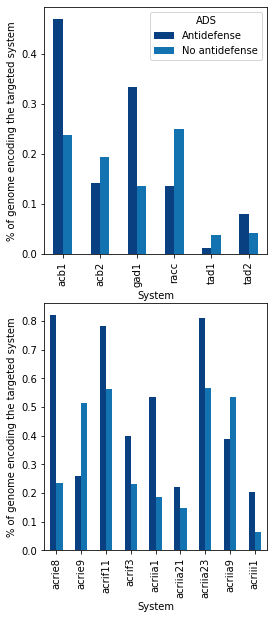

In [24]:
fig,ax=plt.subplots(2,1,figsize=(4,10))

Selected_sys=['gad1','tad1','tad2_acriia7','acb1','acb2','racc']
list_defense=['Gabija','Thoeris','Thoeris','CBASS','CBASS','Retron']
Stats=pd.DataFrame(columns=['ADS', 'Prop_w_sys', 'System'])


for i in range(len(Selected_sys)):
    system=list_defense[i]
    ads_select=Selected_sys[i]

    liste_genus=bact.loc[(bact.System==ads_select)].Genus.unique()

    ads=bact.loc[(bact.System==ads_select)&(bact.Genus.isin(liste_genus))]
    phylo_good=phylo.loc[(phylo.Genus.isin(liste_genus))].drop_duplicates('ID')
    phylo_good['ADS']='No antidefense'
    phylo_good.loc[phylo_good.Assembly.isin(ads.Assembly),'ADS']=ads_select
    phylo_good['DS']='No defense'
    phylo_good.loc[phylo_good.Assembly.isin(defense_sys.loc[defense_sys.System==system,"Assembly"]),'DS']=system


    Stats_no_phylo=phylo_good.groupby(['ADS']).DS.value_counts(normalize=True).to_frame()
    Stats_no_phylo.columns=['Prop']
    Stats_no_phylo=Stats_no_phylo.unstack().reset_index().droplevel(level=0,axis=1)
    Stats_no_phylo.columns=['ADS']+Stats_no_phylo.columns[-2:].to_list()
    Stats_no_phylo['System']=ads_select
    Stats_no_phylo=Stats_no_phylo.rename({system:'Prop_w_sys'},axis=1).drop(columns=['No defense'])
    Stats_no_phylo.loc[Stats_no_phylo.ADS==ads_select,'ADS']='Antidefense'
    # Stats_no_phylo.drop(columns=[system])
    
    Stats=pd.concat([Stats,Stats_no_phylo])

Stats.loc[Stats.System=='tad2_acriia7','System']='tad2'
Stats_tot=Stats.copy()


Stats.pivot_table(index='System',columns='ADS',values='Prop_w_sys').plot.bar(color=['#084081','#1373B1'],ax=ax[0])

list_acr=['acriia21', 'acrie9', 'acriia9', 'acriii1', 'acrif3', 'acrif11',
       'acriia1', 'acrie8', 'acriia23']
list_acr
list_associated_cas=['CAS_Class2-Subtype-II-','CAS_Class1-Subtype-I-',
                     'CAS_Class2-Subtype-II-','CAS_Class1-Subtype-III-',
                    'CAS_Class1-Subtype-I-','CAS_Class1-Subtype-I-',
                    'CAS_Class2-Subtype-II-','CAS_Class1-Subtype-I-',
                    'CAS_Class2-Subtype-II-']

Stats=pd.DataFrame(columns=['ADS', 'Prop_w_sys', 'System'])

for i in range(len(list_associated_cas)):
    system=list_associated_cas[i]
    ads_select=list_acr[i]
    liste_genus=bact.loc[(bact.System==ads_select)].Genus.unique()

    ads=bact.loc[(bact.System.str.contains(ads_select))&(bact.Genus.isin(liste_genus))]
    phylo_good=phylo.loc[(phylo.Genus.isin(liste_genus))].drop_duplicates('ID')
    phylo_good['ADS']='No antidefense'
    phylo_good.loc[phylo_good.Assembly.isin(ads.Assembly),'ADS']=ads_select
    phylo_good['DS']='No defense'
    phylo_good.loc[phylo_good.Assembly.isin(defense_sys.loc[defense_sys.Subsystem.str.contains(system),"Assembly"]),'DS']=system

    try:
        Stats_no_phylo=phylo_good.groupby(['ADS']).DS.value_counts(normalize=True).to_frame()
        Stats_no_phylo.columns=['Prop']
        Stats_no_phylo=Stats_no_phylo.unstack().reset_index().droplevel(level=0,axis=1)
        Stats_no_phylo.columns=['ADS']+Stats_no_phylo.columns[-2:].to_list()
        Stats_no_phylo['System']=ads_select
        Stats_no_phylo=Stats_no_phylo.rename({system:'Prop_w_sys'},axis=1).drop(columns=['No defense'])
        Stats_no_phylo.loc[Stats_no_phylo.ADS==ads_select,'ADS']='Antidefense'
    except:
        print(ads_select)
        # break
    if system=="acrif11":
        break
    Stats=pd.concat([Stats,Stats_no_phylo])
Stats_tot=pd.concat([Stats,Stats_tot])
ax[1].legend_ = None
ax[0].set_ylabel('% of genome encoding the targeted system')
ax[1].set_ylabel('% of genome encoding the targeted system')

Stats.pivot_table(index='System',columns='ADS',values='Prop_w_sys').plot.bar(color=['#084081','#1373B1'],ax=ax[1],legend=None)
plt.show()

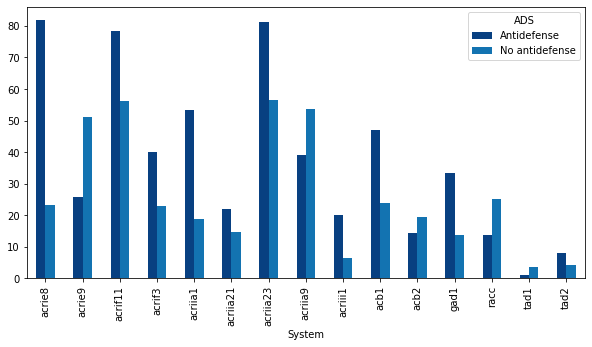

In [25]:
Stats_tot['Percentage']=Stats_tot.Prop_w_sys*100
Stats_tot_pivot=Stats_tot.pivot_table(index="System",columns='ADS',values='Percentage')
Stats_tot_pivot=Stats_tot_pivot.loc[['acrie8', 'acrie9', 'acrif11', 'acrif3', 'acriia1',
       'acriia21', 'acriia23', 'acriia9', 'acriii1', 'acb1', 'acb2', 'gad1', 'racc', 'tad1',
       'tad2']]
fig,ax=plt.subplots(1,1,figsize=(10,5))
Stats_tot_pivot.plot.bar(stacked=False,color=['#084081','#1373B1'],ax=ax)
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure3C.pdf',format='pdf',bbox_inches='tight')

### Figure 3D

In [26]:
bact_sys=bact.drop_duplicates('sys_id')
sys_take=bact_sys.System.value_counts()[bact_sys.System.value_counts()>50].index.to_list()
phage_sys=phage.drop_duplicates('sys_id')
sys_take_phage=phage_sys.System.value_counts()[phage_sys.System.value_counts()>20].index.to_list()
sys_take=sys_take+sys_take_phage

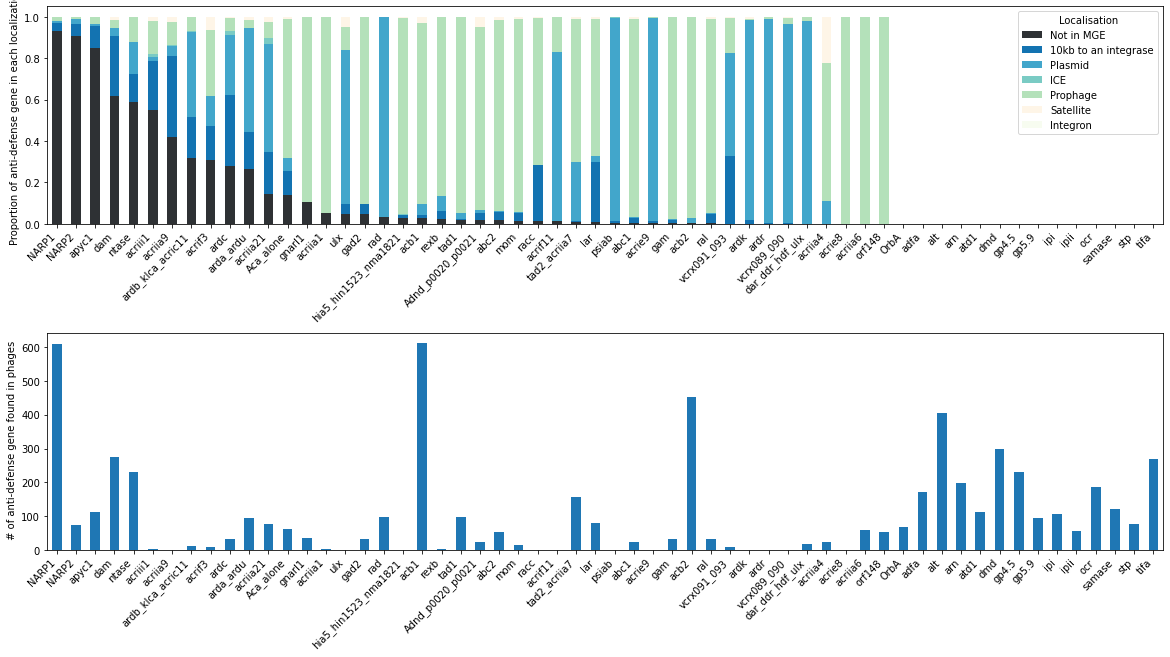

In [27]:
mge_take=bact_sys.loc[bact_sys.System.isin(sys_take)]
mge_plot=mge_take.groupby('System').Localisation.value_counts(normalize=True).to_frame().rename({'Localisation':'Proportion','index':'Localisation'},axis=1).reset_index()
not_in_mge=pd.Series(sys_take)[~pd.Series(sys_take).isin(mge_plot.System)]
mge_plot=pd.concat([mge_plot,pd.DataFrame({'Localisation':['Not in MGE' for x in range(len(not_in_mge))],'System':not_in_mge,'Proportion':[0 for x in range(len(not_in_mge))]})])
mge_plot=mge_plot.pivot_table(index='System',columns=['Localisation'],values=['Proportion']).fillna(0).droplevel(level=0,axis=1)
mge_plot=mge_plot.sort_values(['Not in MGE','10kb to an integrase','Plasmid','ICE','Prophage','Satellite','Integron'],ascending=False)[['Not in MGE','10kb to an integrase','Plasmid','ICE','Prophage','Satellite','Integron']]


sns.set_style(rc = {'axes.facecolor': 'white'})
fig,ax=plt.subplots(2,1,figsize=(20,10))
plt.subplots_adjust(hspace=0.5)

mge_plot.plot.bar(stacked=True,color=["#2e3134","#1373B1","#42A6CB","#7ACBC4","#B4E1BA","#FEF5E7","#F7FCF0"],ax=ax[0])

phage_plot=pd.DataFrame({"System":mge_plot.index}).merge(phage_sys.loc[phage_sys.System.isin(sys_take)].System.value_counts().reset_index().rename({'System':'Nb_sys',"index":'System'},axis=1),on='System',how='left').fillna(0).set_index('System')
phage_plot.plot.bar(ax=ax[1])


ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='center')
# ax[1].set_xticklabels([])
# ax[1].set_ylim(ax[1].get_ylim()[::-1])

ax[0].xaxis.set_ticks_position('bottom')
ax[1].xaxis.set_ticks_position('bottom')
ax[0].set_ylabel('Proportion of anti-defense gene in each localization')
ax[1].set_ylabel(' # of anti-defense gene found in phages')
ax[1].set_xlabel(None)
ax[0].set_xlabel(None)
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/Figure3D.pdf',format='pdf',bbox_inches='tight')
ax[1].legend().set_visible(False)

### Supplementary Figure phage with ADS

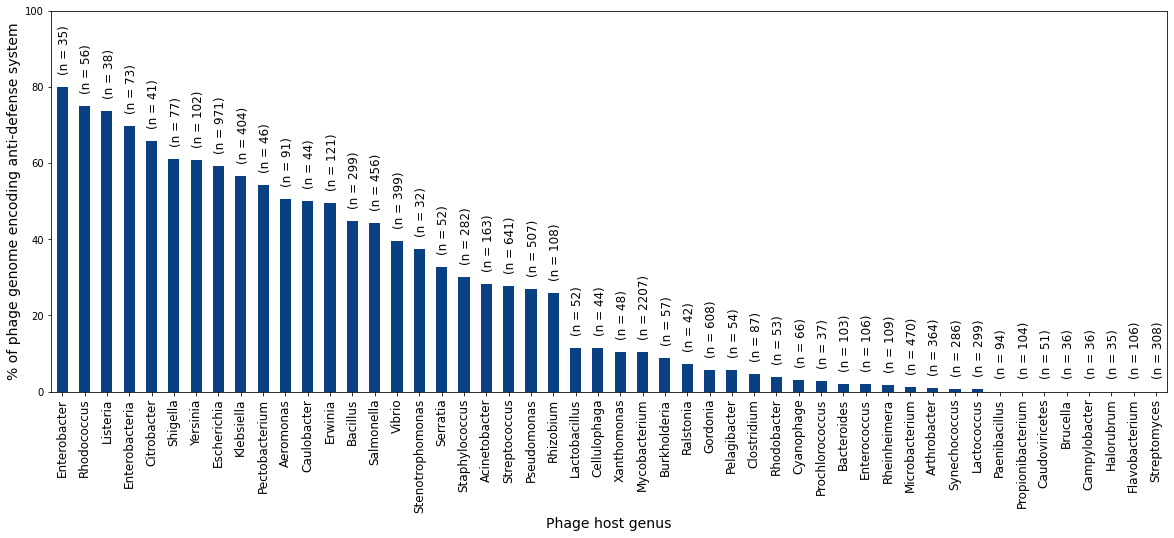

In [28]:
genus_phage=phylo_phage.Genus_source.value_counts()[0:51].to_frame().reset_index().rename({'Genus_source':'Nb_genome','index':'Genus_host'},axis=1)
genus_phage=genus_phage.merge(phylo_phage.loc[phylo_phage.Assembly.isin(phage.Assembly)].Genus_source.value_counts().to_frame().reset_index().rename({'Genus_source':'Genomes_w_ADS','index':'Genus_host'},axis=1),on='Genus_host',how='left').fillna(0)
genus_phage['Prct_w_ADS']=genus_phage.Genomes_w_ADS*100/genus_phage.Nb_genome
genus_phage=genus_phage.loc[genus_phage.Genus_host!='uncultured']
genus_phage=genus_phage.sort_values('Prct_w_ADS',ascending=False).reset_index(drop=True)
genus_phage['Genus_nb']='(n = '+genus_phage.Nb_genome.map(str)+')'
fig,ax=plt.subplots(1,1,figsize=(20,7))
genus_phage.set_index("Genus_host").Prct_w_ADS.plot.bar(color='#084081')

for i in genus_phage.index.to_list():
    ax.text(s=genus_phage.Genus_nb[i],x=i+0.1,y=genus_phage.Prct_w_ADS[i]+ 4,rotation=90,horizontalalignment='center',size=12)

ax.set_xticklabels(ax.get_xticklabels(),size=12)
ax.set_ylabel('% of phage genome encoding anti-defense system',size=14)
ax.set_xlabel('Phage host genus',size=14)


plt.ylim(0,100)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('results/figures/SuppFigure_phage_w_ADS.pdf',format='pdf',bbox_inches='tight')
